In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import os
import glob
warnings.filterwarnings('ignore')
%matplotlib inline

### EDA
- Payment Type
- Order
- Product & Category
- Review score & Delivery time
- Geolocation

### Analytics - Part1 (Cohort, LTV, Retention) 
- Cohort-wise revenue
- Cohort-wise # of clients
- Cohort-wise LTV
- Cohort-wise Retention rate

### Analytics - Part2 (Segmentation)
- RFM
- Elbow method & Silhouette score
- Kmeans & DBSCAN
- Visualization of clusters

### Analytics - Part3 (Churn prediction)
- Define churn and create label
- Comparing various ML models
- Predict customer churn 

*******************************************************************************************************************************************************************

### Data

In [2]:
path = './datasets/'
filenames = glob.glob(path + "*.csv")
file_list = []
for file in sorted(filenames):
    file_list.append(pd.read_csv(file))

In [3]:
customers = file_list[0]
geolocation = file_list[1]
items = file_list[2]
payments = file_list[3]
reviews = file_list[4]
orders = file_list[5]
products = file_list[6]
sellers = file_list[7]
categories = file_list[8]

### Payment Data EDA

In [4]:
# null check
payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [5]:
# payment types
payments.payment_type.value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [7]:
# payment installments
installments = payments[payments.payment_type == 'credit_card']

Text(0.5, 1.0, 'Payment installments in credit card')

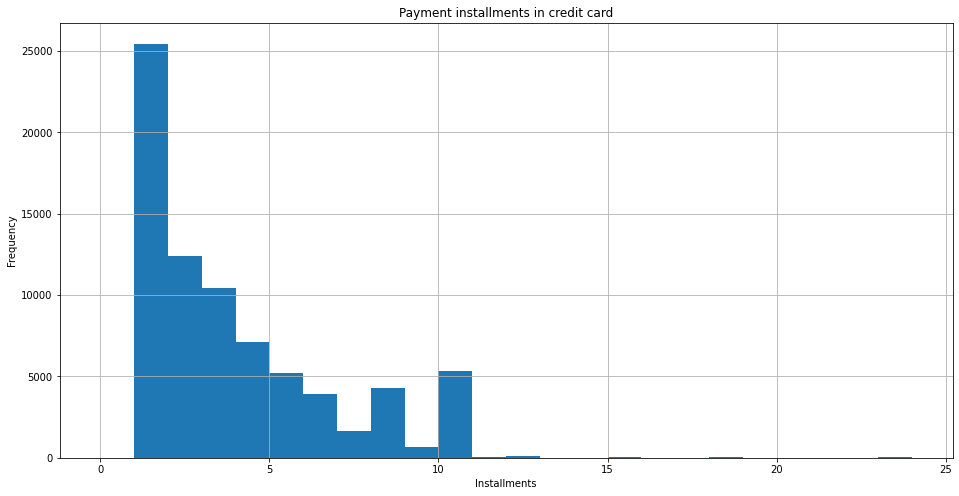

In [8]:
fig, ax = plt.subplots(figsize = (16,8))
installments.hist(column='payment_installments', bins = installments.payment_installments.nunique(), ax=ax)
plt.xlabel("Installments")
plt.ylabel("Frequency")
plt.title("Payment installments in credit card")

<AxesSubplot:xlabel='payment_type'>

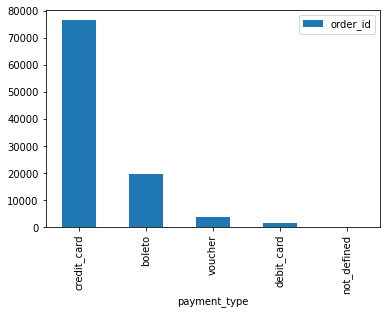

In [72]:
payment_types = payments.groupby('payment_type')[['order_id']].nunique()
payment_types.sort_values('order_id', ascending=False, inplace=True)
payment_types.plot(kind='bar')

In [9]:
# payment value
def detect_outliers(df = payments, col = 'payment_value'):
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3-q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return df[(df[col] <= upper_bound) & (df[col] >= lower_bound)]

In [10]:
# remove 'not_defined' payment_type class
df_within_outliers = detect_outliers(payments[payments.payment_type != 'not_defined'])

Text(0.5, 1.0, 'Distribution of payment value by each payment method')

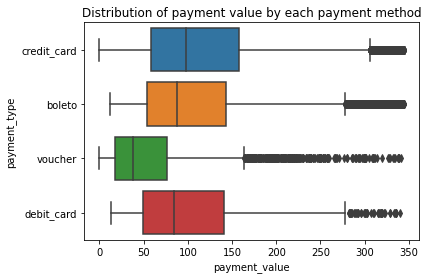

In [136]:
# distributions of payment value in each payment type
sns.boxplot(df_within_outliers, x='payment_value', y='payment_type')
plt.title("Distribution of payment value by each payment method")

### Order Data EDA

In [73]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [74]:
tmp_orders = orders.copy()
tmp_orders = tmp_orders[['order_id', 'order_purchase_timestamp', 'order_status','order_delivered_customer_date', 'order_estimated_delivery_date']]

In [75]:
# %Y-%m-%d format
order_purchase_timestamp = pd.to_datetime(tmp_orders.order_purchase_timestamp)
tmp_orders.order_delivered_customer_date = pd.to_datetime(tmp_orders.order_delivered_customer_date)
tmp_orders.order_estimated_delivery_date = pd.to_datetime(tmp_orders.order_estimated_delivery_date)

- Order Status

In [81]:
tmp_orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [92]:
# remove both created and approved
order_status = tmp_orders[(tmp_orders.order_status != 'created') & (tmp_orders.order_status != 'approved')]
order_status = order_status.groupby('order_status')['order_id'].nunique()

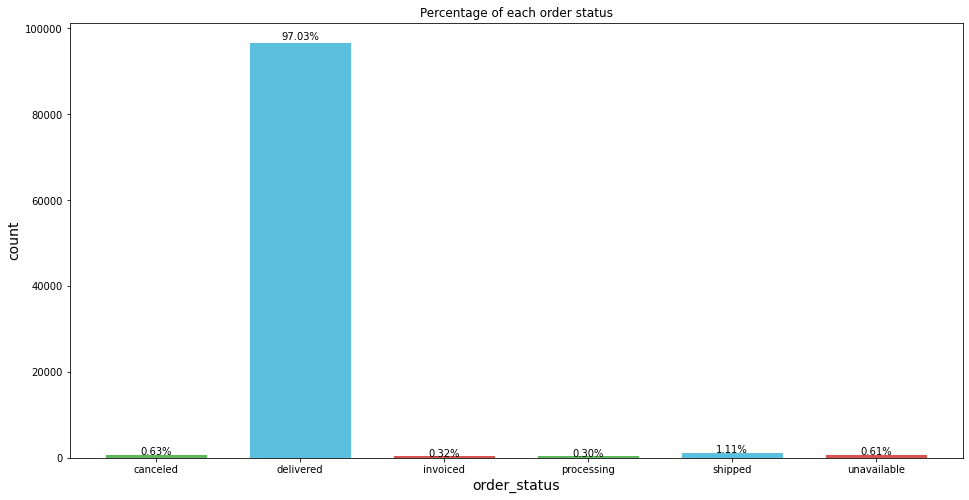

In [129]:
colors_list = ['#5cb85c','#5bc0de','#d9534f']

ax = order_status.plot(kind='bar',figsize=(16,8),width = 0.7,color = colors_list)
plt.xlabel("order_status", fontsize = 14) 
plt.ylabel('count', fontsize=14)
plt.xticks(rotation=0)
plt.title("Percentage of each order status")

for p in ax.patches:
    width = p.get_width()
    height = p.get_height() / order_status.values.sum()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*order_status.values.sum()*1.01), ha='center')

- Orders in each month

<AxesSubplot:xlabel='order_purchase_timestamp'>

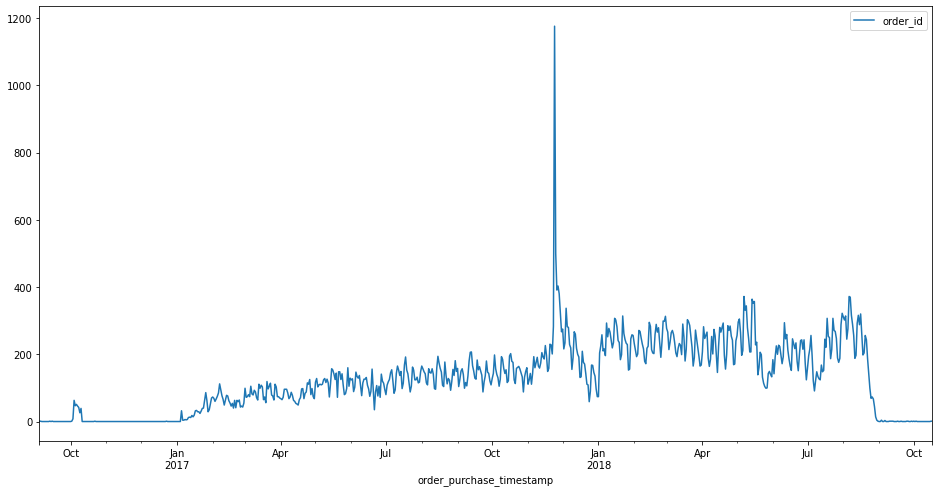

In [202]:
df_cnt = tmp_orders.set_index("order_purchase_timestamp").groupby(pd.Grouper(freq='D')).count()
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
df_cnt.plot(y = "order_id", use_index=True, ax=ax)

There were so many orders in Dec 2017 and it's probably because of the Christmas and New Year's Eve

- Orders by weekday

In [250]:
order_day = tmp_orders.copy()
order_day.order_purchase_timestamp = order_day.order_purchase_timestamp.dt.day_name()
order_day = order_day.groupby('order_purchase_timestamp')['order_id'].count()

In [254]:
order_day = order_day.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

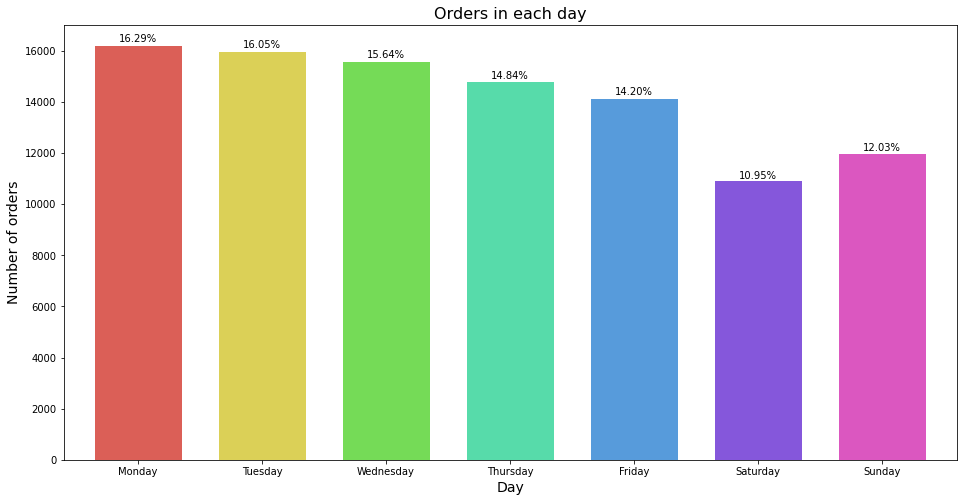

In [256]:
colors = sns.color_palette('hls',len(order_day))

ax = order_day.plot(kind='bar',figsize=(16,8),width = 0.7, color = colors)
plt.xlabel("Day", fontsize = 14) 
plt.ylabel('Number of orders', fontsize=14)
plt.xticks(rotation=0)
plt.title("Orders in each day", fontsize=16)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height() / order_day.values.sum()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*order_day.values.sum().sum()*1.01), ha='center')

### Product & Category EDA